In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from ethos.constants import PROJECT_DATA, PROJECT_ROOT
from ethos.tokenize import SpecialToken, Vocabulary
from ethos.utils import load_model_from_checkpoint

In [2]:

model, _ = load_model_from_checkpoint(
    PROJECT_ROOT / "out/mimic_layer_6_batch_32_do_0.3/best_model.pt", "cpu", for_training=False,
    return_attention=True)
vocab = Vocabulary(PROJECT_DATA / "tokenized_datasets/mimic_vocab_t4367.pkl")
q_tokens = vocab.encode(SpecialToken.DECILES)
time_tokens = vocab.encode(SpecialToken.SEPARATOR_NAMES).astype(int)
year_tokens = vocab.encode(SpecialToken.YEAR_NAMES).astype(int)

number of parameters: 45.87M


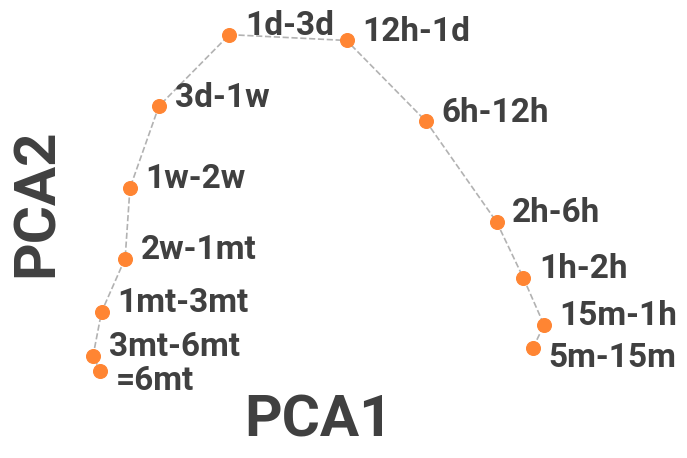

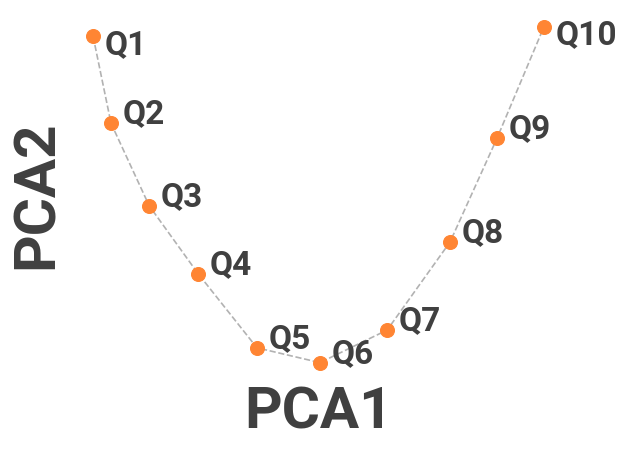

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

black_color = "#404040ff"
gray_color = "#b2b2b2ff"
orange_color = "#ff8533ff"
font_size = 42

sns.set(context="paper", style="white")

plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['text.color'] = black_color  # Set global text color using hex code
plt.rcParams['font.weight'] = 'bold'  # Set global font weight
plt.rcParams['axes.labelweight'] = 'bold'  # Set global weight for axis labels
plt.rcParams['axes.labelcolor'] = black_color  # Set global color for axis labels
plt.rcParams['xtick.color'] = black_color  # Set global color for xtick labels
plt.rcParams['ytick.color'] = black_color  # Set global color for ytick labels
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['axes.titleweight'] = 'bold'  # Make titles bold
plt.rcParams['axes.titlecolor'] = black_color
plt.rcParams['axes.labelsize'] = font_size

plot_data = [
    ("time_tokens", time_tokens, SpecialToken.SEPARATOR_NAMES),
    ("quantiles", q_tokens, SpecialToken.DECILES),
    # ("year_tokens", year_tokens, SpecialToken.YEAR_NAMES)
]

for name, tokens, labels in plot_data:
    token_weights = model.transformer.wte.weight[tokens].detach().numpy()
    coords = PCA(n_components=2, random_state=42).fit_transform(token_weights)
    x_vals, y_vals = coords.T

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(False)
    ax.set(xticks=[], yticks=[], xlabel="PCA1", ylabel="PCA2")
    ax.set_frame_on(False)

    ax.scatter(x_vals, y_vals, color=orange_color, s=100, zorder=10)
    ax.plot(x_vals, y_vals, color=gray_color, ls="--")

    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        label = labels[i][1:]
        y_offset = 0.04 if i in (0, len(x_vals) - 1) else 0
        ax.text(x + 0.03, y - y_offset, label, fontsize=24, color=black_color)

In [4]:
vocabulary = pd.DataFrame(vocab.stoi.items(), columns=["token", "group"])
vocabulary["group"] = np.nan
vocabulary.group = vocabulary.group.astype(object)
vocabulary.loc[lambda _df: _df.token.isin(SpecialToken.SEPARATOR_NAMES), "group"] = "time_intervals"
vocabulary.loc[lambda _df: _df.token.isin(SpecialToken.DECILES), "group"] = "quantiles"
vocabulary.loc[lambda _df: _df.token.isin(SpecialToken.YEAR_NAMES), "group"] = "years"
vocabulary.loc[
    lambda _df: _df.token.str.startswith("_") & _df.group.isna(), "group"] = "special_token"
vocabulary.loc[lambda _df: _df.token.str.startswith("ICD_PCS"), "group"] = "procedure"
vocabulary.loc[
    lambda _df: _df.token.str.startswith("ICD") & _df.group.isna(), "group"] = "diagnosis"
vocabulary.loc[lambda _df: _df.token.str.startswith("ATC"), "group"] = "medication"
vocabulary.loc[lambda _df: _df.token.str.startswith("LAB"), "group"] = "lab"
vocabulary.loc[lambda _df: _df.token.str.startswith("TRANSFER"), "group"] = "transfer"
vocabulary.loc[62:851, "group"] = "admission"
vocabulary.loc[871:882, "group"] = "icu"
vocabulary.loc[lambda _df: _df.group.isna(), "group"] = "other"
vocabulary

,token,group
0,_5m-15m,time_intervals
1,_15m-1h,time_intervals
2,_1h-2h,time_intervals
3,_2h-6h,time_intervals
4,_6h-12h,time_intervals
...,...,...
4362,"LAB_Bilirubin, Total_mg/dL",lab
4363,LAB_NTproBNP_pg/mL,lab
4364,LAB_STX6_no_unit,lab
4365,LAB_pH_no_unit,lab


In [5]:
from ethos.tokenize.constants import DataProp
from ethos.tokenize.mimic.code_translation import IcdCmTranslation
from sklearn.manifold import TSNE

icd_prefix = vocabulary.loc[
    lambda _df: (_df.group == "diagnosis")
                & ~_df.token.str.startswith("ICD_4")
                & ~_df.token.str.startswith("ICD_6")
]
token_weights = model.transformer.wte.weight.detach().numpy()[icd_prefix.index]
coords = TSNE(n_components=2, random_state=42, n_jobs=10).fit_transform(token_weights)

In [6]:
data_prop = DataProp.create("mimic", "test")
trans = IcdCmTranslation(data_prop)
coords = pd.DataFrame(coords, columns=["x", "y"], index=icd_prefix.index)
coords["token"] = icd_prefix.token
coords.token = coords.token.str[4:].map(trans.name_to_code).str[:1]
gen = (i for _ in range(0, 10) for i in range(0, 3))
coords["token_style"] = coords.token.map(dict(zip(coords.token.unique(), gen)))
coords

,x,y,token,token_style
883,9.041593,-2.070923,Q,0
887,14.905856,15.729820,F,1
888,-5.049494,7.140695,X,2
892,2.237031,-4.483850,Q,0
893,17.100115,-3.282862,A,0
...,...,...,...,...
3811,18.242428,5.710244,N,1
3812,6.061235,-0.120019,F,1
3813,25.383699,-0.509185,A,0
3815,23.461676,13.653159,N,1


[[], [], Text(0.5, 0, 't-SNE1'), Text(0, 0.5, 't-SNE2')]

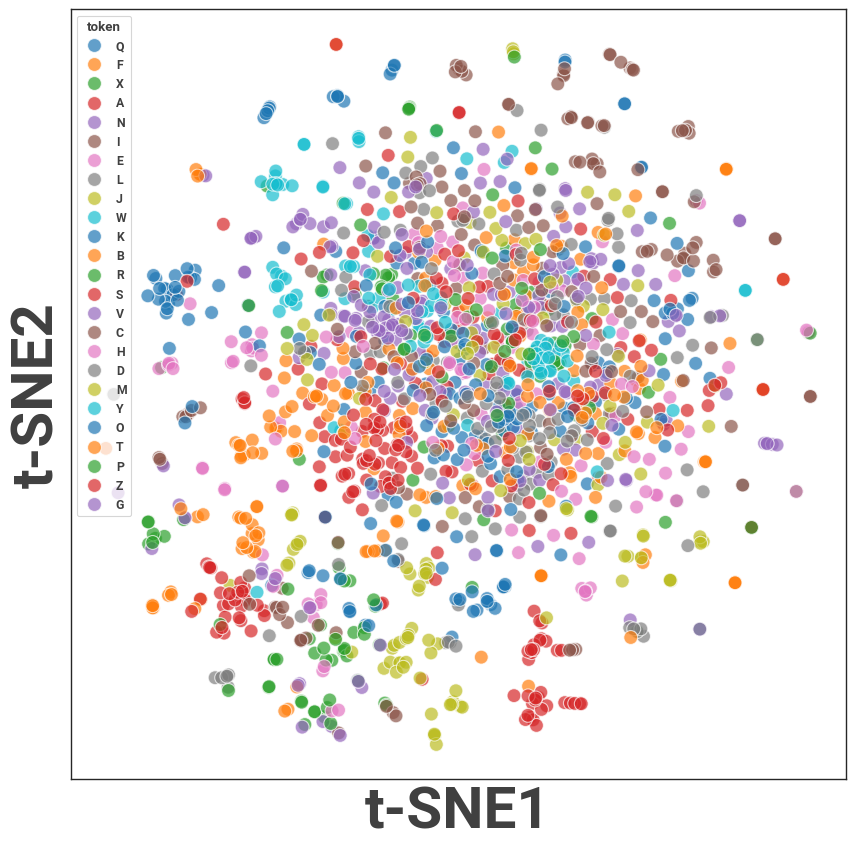

In [7]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data=coords, x="x", y="y", hue="token",
                     palette="tab10", s=100, alpha=0.7)
ax.set(xticks=[], yticks=[], xlabel="t-SNE1", ylabel="t-SNE2")